In [27]:
import numpy as np
from scipy.optimize import minimize
from cvxopt import matrix, solvers
import os
import sys

In [28]:
#Prereq Stuff
from scipy.spatial.distance import cdist
from matplotlib import pyplot as plt


def linearKernel(X1, X2):
    return X1 @ X2.T


def polyKernel(X1, X2, degree):
    return (X1 @ X2.T + 1) ** degree


def gaussKernel(X1, X2, width):
    distances = cdist(X1, X2, 'sqeuclidean')
    return np.exp(- distances / (2*(width**2)))


def generateData(n, gen_model):

    # Controlling the random seed will give you the same 
    # random numbers every time you generate the data. 
    # The seed controls the internal random number generator (RNG).
    # Different seeds produce different random numbers. 
    # This can be handy if you want reproducible results for debugging.
    # For example, if your code *sometimes* gives you an error, try
    # to find a seed number (0 or others) that produces the error. Then you can
    # debug your code step-by-step because every time you get the same data.

    # np.random.seed(0)  # control randomness when debugging

    if gen_model == 1 or gen_model == 2:
        # Gen 1 & 2
        d = 2
        w_true = np.ones([d, 1])

        X = np.random.randn(n, d)

        if gen_model == 1:
            y = np.sign(X @ w_true)  # generative model 1
        else:
            y = np.sign((X ** 2) @ w_true - 1)  # generative model 2

    elif gen_model == 3:
        # Gen 3
        X, y = generateMoons(n)

    else:
        raise ValueError("Unknown generative model")

    return X, y


def generateMoons(n, noise=0.1):
    n_samples_out = n // 2
    n_samples_in = n - n_samples_out
    outer_circ_x = np.cos(np.linspace(0, np.pi, n_samples_out))
    outer_circ_y = np.sin(np.linspace(0, np.pi, n_samples_out))
    inner_circ_x = 1 - np.cos(np.linspace(0, np.pi, n_samples_in))
    inner_circ_y = 1 - np.sin(np.linspace(0, np.pi, n_samples_in)) - 0.5

    X = np.vstack(
        [np.append(outer_circ_x, inner_circ_x), 
         np.append(outer_circ_y, inner_circ_y)]
    ).T
    X += np.random.randn(*X.shape) * noise

    y = np.hstack(
        [-np.ones(n_samples_out, dtype=np.intp), 
         np.ones(n_samples_in, dtype=np.intp)]
    )[:, None]
    return X, y


def plotPoints(X, y):
    # plot the data points from two classes
    X0 = X[y.flatten() >= 0]
    X1 = X[y.flatten() < 0]

    plt.scatter(X0[:, 0], X0[:, 1], marker='x', label='class -1')
    plt.scatter(X1[:, 0], X1[:, 1], marker='o', label='class +1')
    return


def getRange(X):
    x_min = np.amin(X[:, 0]) - 0.1
    x_max = np.amax(X[:, 0]) + 0.1
    y_min = np.amin(X[:, 1]) - 0.1
    y_max = np.amax(X[:, 1]) + 0.1
    return x_min, x_max, y_min, y_max


def plotModel(X, y, w, w0, classify):

    plotPoints(X, y)

    # plot model
    x_min, x_max, y_min, y_max = getRange(X)
    grid_step = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, grid_step),
                         np.arange(y_min, y_max, grid_step))
    z = classify(np.c_[xx.ravel(), yy.ravel()], w, w0)

    # Put the result into a color plot
    z = z.reshape(xx.shape)
    plt.contourf(xx, yy, z, cmap=plt.cm.RdBu, alpha=0.5)
    plt.legend()
    plt.show()
    return


def plotAdjModel(X, y, a, a0, kernel_func, adjClassify):

    plotPoints(X, y)

    # plot model
    x_min, x_max, y_min, y_max = getRange(X)
    grid_step = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, grid_step),
                         np.arange(y_min, y_max, grid_step))
    z = adjClassify(np.c_[xx.ravel(), yy.ravel()], a, a0, X, kernel_func)

    # Put the result into a color plot
    z = z.reshape(xx.shape)
    plt.contourf(xx, yy, z, cmap=plt.cm.RdBu, alpha=0.5)
    plt.legend()
    plt.show()
    return


def plotDualModel(X, y, a, b, lamb, kernel_func, dualClassify):

    plotPoints(X, y)

    # plot model
    x_min, x_max, y_min, y_max = getRange(X)
    grid_step = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, grid_step),
                         np.arange(y_min, y_max, grid_step))
    z = dualClassify(np.c_[xx.ravel(), yy.ravel()], a, b, X, y, 
                     lamb, kernel_func)

    # Put the result into a color plot
    z = z.reshape(xx.shape)
    plt.contourf(xx, yy, z, cmap=plt.cm.RdBu, alpha=0.5)
    plt.legend()
    plt.show()

    return


def plotDigit(x):
    img = x.reshape((28, 28))
    plt.imshow(img, cmap='gray')
    plt.show()
    return



In [29]:
def dualClassify(Xtest, a, b, X, y, lamb, kernel_func):
    
    n = Xtest.shape[0]
    K= kernel_func(Xtest, X)
    
    predictions = (1 / lamb) * K @ np.diag(y.flatten()) @  a + b
    
    yhat = np.sign(predictions)
    
    return yhat

     pcost       dcost       gap    pres   dres
 0: -6.0952e+00 -1.2726e+02  1e+02  1e-16  3e-16
 1: -7.6449e+00 -1.6200e+01  9e+00  2e-15  3e-16
 2: -8.1550e+00 -8.5717e+00  4e-01  2e-15  8e-17
 3: -8.1809e+00 -8.1917e+00  1e-02  8e-16  6e-17
 4: -8.1830e+00 -8.1833e+00  4e-04  3e-15  7e-17
 5: -8.1832e+00 -8.1832e+00  3e-05  4e-15  6e-17
 6: -8.1832e+00 -8.1832e+00  1e-06  2e-15  6e-17
Optimal solution found.
slphas shape (100, 1)
bs shape (1,)


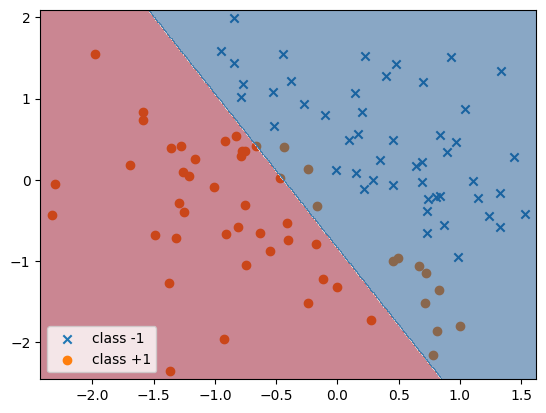

In [37]:
def dualHinge(X, y, lamb, kernel_func, stabilizer=1e-5):

    n, d = X.shape
    #print("n = ", n)
    #print("d = ", d)
    K = kernel_func(X, X) 


    P = np.eye(n) 
    P = (1/lamb) * (np.eye(n)*y) * K * (np.eye(n)*y) # Kernel matrix for alpha terms
    P = matrix(P + stabilizer * np.eye(n))  # Stabilization

    q = matrix(-np.ones(n))
    
    # Create G matrix
    G1 = -np.eye(n)
    G2 = np.eye(n)
    G = np.vstack([G1, G2])  # Stack G1 and G2 to form the full G matrix
    
    h = np.concatenate([np.zeros(n), np.ones(n)]) 

    #Au = b which well use for our perpendicular constraint
    A = y.T
    b = 0.

    # Convert 
    A = matrix(A)
    b = matrix(b)
    P = matrix(P)
    q = matrix(q)
    G = matrix(G)
    h = matrix(h)

    solution = solvers.qp(P, q, G, h,A,b)
    alphas = np.array(solution['x'][:n])
     
    i = np.argmin(np.abs(alphas - 0.5))
    b =  y[i] - ((1/lamb) * K[i].T @ (np.eye(n)*y) @ alphas)

    return alphas, b




# Example usage
X,y = generateData(100,1)
lamb = 0.1# Regularization parameter

kernel_func = lambda X1, X2 : linearKernel(X1,X2)

a, b = dualHinge(X, y, lamb,kernel_func)

print("slphas shape", a.shape)
print("bs shape",b.shape)
#print("Optimized weights:", a.flatten())
#print("Optimized bias:", b)

plotDualModel(X,y,a,b,lamb,kernel_func,dualClassify)



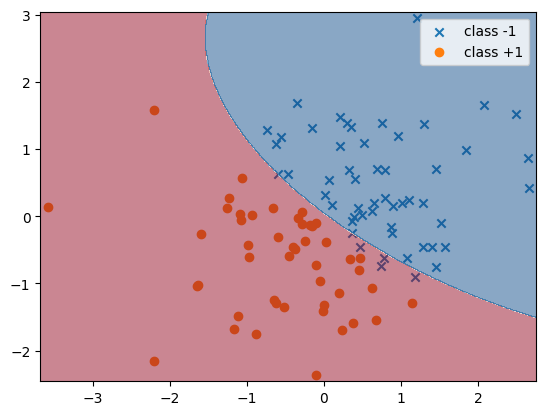

In [38]:
def _plotCls():

	n = 100
	lamb = 0.01
	gen_model = 1
	kernel_func = lambda X1, X2: polyKernel(X1, X2, 2)

	# Generate data
	Xtrain, ytrain = generateData(n=n, gen_model=gen_model)

	# Learn and plot results
	# Primal
	#w, w0 = A2codes.minBinDev(Xtrain, ytrain, lamb)
	#plotModel(Xtrain, ytrain, w, w0, A2codes.classify)
	# Adjoint
	#a, a0 = A2codes.adjHinge(Xtrain, ytrain, lamb, kernel_func)
	#plotAdjModel(Xtrain, ytrain, a, a0, kernel_func, A2codes.adjClassify)
	# Dual
	#a, b = A2codes.dualHinge(Xtrain, ytrain, lamb, kernel_func)
	plotDualModel(Xtrain, ytrain, a, b, lamb, kernel_func, dualClassify)


_plotCls()